# modules import

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# 전처리 설정

In [74]:
help(transforms)

Help on package torchvision.transforms in torchvision:

NAME
    torchvision.transforms

PACKAGE CONTENTS
    _functional_video
    _transforms_video
    functional
    functional_pil
    functional_tensor
    transforms

FILE
    /opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/__init__.py




In [46]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

# 데이터 로드 및 데이터 확인

In [47]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [48]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

In [49]:
image, label = next(iter(train_loader))

In [50]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [51]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

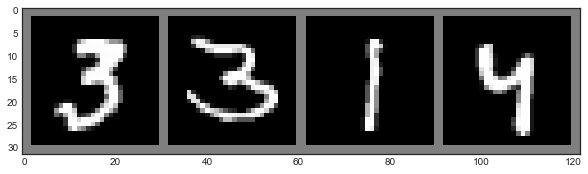

In [52]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

# 신경망 구성

In [76]:
# ? nn.Conv2d

In [53]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x # (128, 10)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [54]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [55]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


# 임의의 값을 넣어 forward값 확인

In [82]:
input = torch.randn(1, 1, 28, 28)

In [83]:
out = net(input)
print(out)

tensor([[-0.1285, -5.2721,  2.1186,  1.5685, -0.2054,  1.7741,  1.5015, -4.9603,
          2.3611, -2.0220]], grad_fn=<AddmmBackward>)


# 손실 함수와 옵티마이저

In [58]:
criterion = nn.CrossEntropyLoss() # loss 값을 계산해주는 객체
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 모델 학습
* optimizer.zero_grad: 가중치의 그래디언트 초기화
* loss 계산
* loss.backward()
* optmizer.step(): 업데이트

* 배치수 확인

In [59]:
tatal_batch = len(train_loader)
print(tatal_batch)

469


* epochs=2 설정

In [60]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad() # 초기화
        
        outputs = net(inputs) # 모델에 input 데이터 넣기
        loss = criterion(outputs, labels) # loss 계산
        loss.backward() # 모델 내의 parameter update
        optimizer.step() # optimizer내의 paramters update
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f'Epoch: {epoch + 1}, Iter: {i + 1}, Loss: {running_loss / 2000}')
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.1150859454870224
Epoch: 1, Iter: 200, Loss: 0.11462234699726105
Epoch: 1, Iter: 300, Loss: 0.11404085552692414
Epoch: 1, Iter: 400, Loss: 0.1132456294298172
Epoch: 2, Iter: 100, Loss: 0.11028942465782166
Epoch: 2, Iter: 200, Loss: 0.10519226634502411
Epoch: 2, Iter: 300, Loss: 0.090117418050766
Epoch: 2, Iter: 400, Loss: 0.06083195987343788


# 모델의 저장 및 로드
* torch.save
 * net.state_dict()를 저장
* torch.load
 * load_state_dict()로 모델을 로드 

In [62]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [63]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [64]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

# 모의 테스트

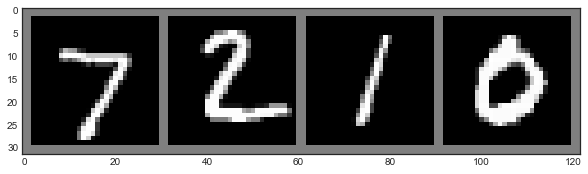

In [65]:
data_iter = iter(test_loader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [66]:
outputs = net(images)

In [68]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 9, 9, 5, 9, 0, 6, 9, 0, 1, 3, 9, 7, 2, 4, 9, 6, 4, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 2, 6, 4, 1, 9, 9, 7, 8, 9, 8, 7, 4, 4, 4, 3, 0, 7, 0,
        2, 8, 1, 7, 3, 7, 9, 7, 9, 6, 2, 7, 8, 4, 7, 6, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 9, 6, 9, 6, 0, 5, 4, 4, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 4, 9, 4, 9, 9,
        5, 4, 7, 6, 7, 4, 0, 5])


In [70]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

7	2	1	0	


In [71]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(100 * correct / total)

82.59
